## Статистический анализ временных рядов с помощью вейвлет-преобразований

Студент 3 курса ФПМИ:
- Цуранов Никита Васильевич

Научный руководитель:
- Лобач Виктор Иванович, доцент кафедры ММАД

## Что такое вейвлеты?

Их можно задать через материнский вейвлет и маштабирующую функцию, но на материнский вейвлет наложены следующие ограничения:
- $\psi(x)$ абсолютно интегрируема и принадлежит пространству $L^2$, т.е. 		
    $$
        \int_{-\infty}^{\infty} |\psi(x)|dx < \infty 
		\text{ и }
		\int_{-\infty}^{\infty} |\psi(x)|^2dx < \infty 
	$$
- Среднее равно нулю, а норма равна единице:
	$$
		\langle f, g \rangle = \int_{-\infty}^{\infty} f(x)g(x)dx
		\text{ - скалярное произведение в }L^2
	$$ 
	$$
		\int_{-\infty}^{\infty} \psi(x)dx = 0 
		\text{ и }
		\int_{-\infty}^{\infty} \psi(x)^2dx = 1
	$$

Рассмотрим самые простые вейвлеты - вейвлеты Хаара:

Материнская функция задается следующим образом: 
	$$
		\psi(x) = 
		\begin{cases}
			 1, & x \in [0, 0.5) \\
			-1, & x \in [0.5, 1) \\
			 0, & \text{иначе}
		\end{cases}
	$$
		
Масштабирующая функция определяется как:
	$$
		\phi(x) =
		\begin{cases}
			1, & x \in [0, 1) \\
			0, & \text{иначе}
		\end{cases}
	$$

Из материнского вейвлета можно построить базис, причем в случае вейвлетов Хаара, ортогональный. Дальнейшее применение будет по аналогии с рядами Фурье.

Система базисных вейвлетов получается путем растяжения и смещения материнского вейвлета:

$$ 
    \psi_{a, b}(x) = 2^{\frac{a}{2}}\psi(2^at-b);
    a \in N_0, b = 0...2^a-1
$$

Смещение, обычно, берется кратное степени двойки

## Преобразование Фурье

Преобразование Фурье функции вещественной переменной задается формулой:
$$ \hat{f}(w) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(x) e^{-ixw} dx $$
Формула обращения:
$$ f(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \hat{f}(w) e^{ixw} dw $$
	

В контексте анализа временных рядов, которые можно рассматривать как сигналы, преобразование Фурье позволяет перевести сигнал из временного представления в частотное.
	
Но у преобразования Фурье есть недостаток. Т.к. мы получаем только частотный спектр, то оно подходит для работы только с периодическими функциями, т.к. иначе два разных сигнала могут давать схожие результаты, а также не подходит для восстановления сигнала. Частично справиться с недостатками помогает оконное преобразование Фурье.

Вейвлет-преобразование $ W(a,b) = \int_{-\infty}^{\infty} f(x) \psi_{a, b}(x)dx $ отличается от преобразования Фурье выбором анализирующей функции. Но для разложения в ряд Фурье мы накладывали условие ортогональности, и благодаря этому мы раскладывали функцию по заданному базису. С вейвлетами, в общем случае, мы так сделать не можем, но мы можем посмотреть насколько заданная функция похожа на наш вейвлет в заданный момент времени.

In [1]:
import pywt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
X_range = np.arange(1000)      

def describe(signal):
    plt.figure(figsize=(11, 6), dpi=120)
    signal_with_noise = signal + np.random.normal(0, 1, len(signal))

    plt.subplot(3, 1, 1)
    plt.plot(signal_with_noise, 'gray', label='noised signal')
    plt.plot(signal, 'black', label='pure signal', linewidth=2)
    plt.xticks(()), plt.yticks(())
    plt.title('Signal')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(np.abs(np.fft.rfft(signal_with_noise)), 'black')
    plt.title('Fourier transform')
    plt.xticks(()), plt.yticks(())

    ax = plt.subplot(3, 1, 3)
    coef, freqs=pywt.cwt(signal ,np.arange(1, 120),'mexh')
    ax.matshow(coef, cmap='Greys')
    plt.title('Сontinuous wavelet transform')
    plt.xticks(()), plt.yticks(())
    plt.show()

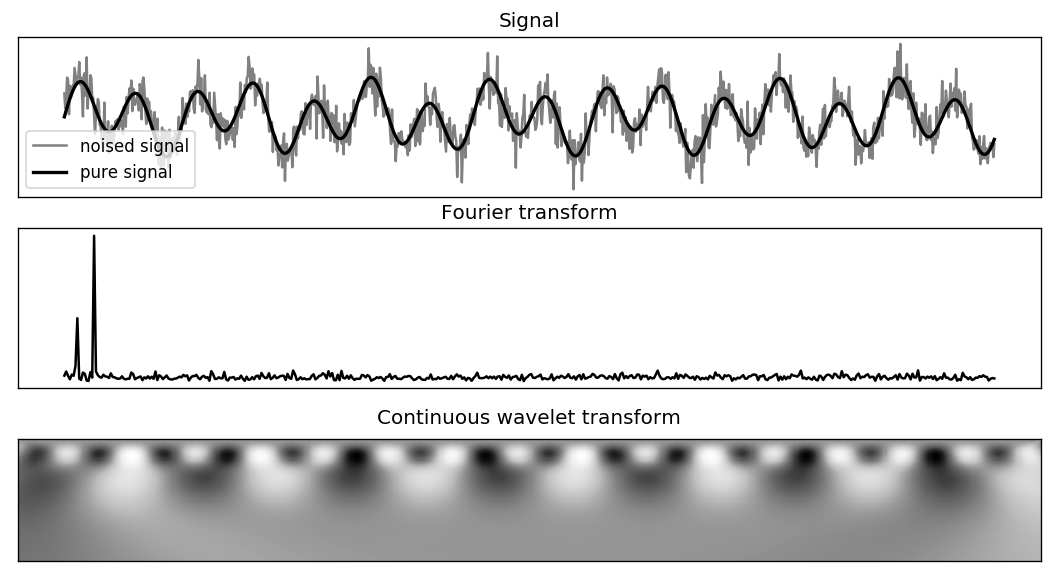

In [4]:
describe(np.sin(X_range / 23) + 2 * np.sin(X_range / 10))

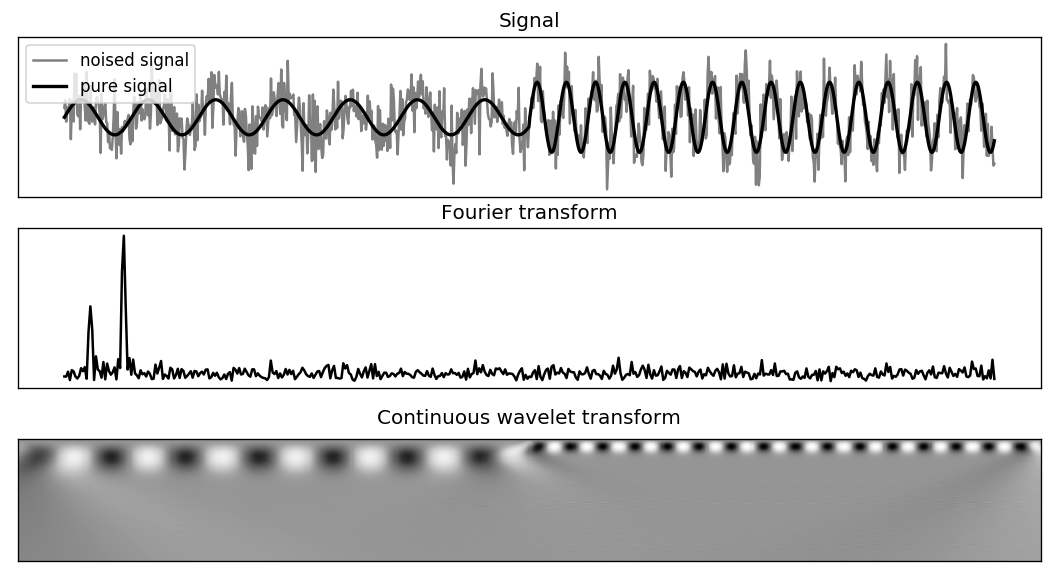

In [5]:
describe(np.append(np.sin(X_range[::2] / 23), 2 * np.sin(X_range[::2] / 10)))

In [6]:
from scipy import integrate

class wavelet_series:
    def __init__(self, g, levels=8):
        self.levels = levels
        mother_wavelet = lambda x: 0 if x < 0 else 1 if x < 0.5 else -1 if x < 1 else 0

        self.scaling = lambda x: 1 if 0 <= x < 1 else 0

        self.basis = [[
                (lambda i, j: lambda x: 2 ** (i / 2) * mother_wavelet(2**i * x - j))(i, j)
            for j in range(2 ** i)] for i in range(levels)]

        self.coef = [[
                integrate.quad(lambda x: g(x) * self.basis[i][j](x), 0, 1)[0] 
            for j in range(2 ** i)] for i in range(levels)]

        self.scaling_coef = integrate.quad(
            lambda x: g(x) * self.scaling(x), 0, 1)[0]
        
    def __call__(self, point):
        value = 0
        for i in range(self.levels):
            for j in range(2 ** i):
                value += self.coef[i][j] * self.basis[i][j](point)
        return value + self.scaling_coef * self.scaling(point)

In [7]:
def decompose_by_levels(g, xs):
    plt.figure(figsize=(16, 8))

    for i in range(1, 7):
        f = wavelet_series(g, i)
        plt.subplot(2, 3, i)
        plt.plot(xs, list(map(g, xs)), 'grey', label='exp(x/3) sin(3x) + 3')
        plt.plot(xs, list(map(f, xs)), 'black', label='Wavelet-transform level %d' % i)
        plt.legend()

        if i == 5:
            plt.xlabel('Continues Haar transform')

    plt.show()

## Рассмотрим как различные базисы влияют
## на разложение одной и той же функции

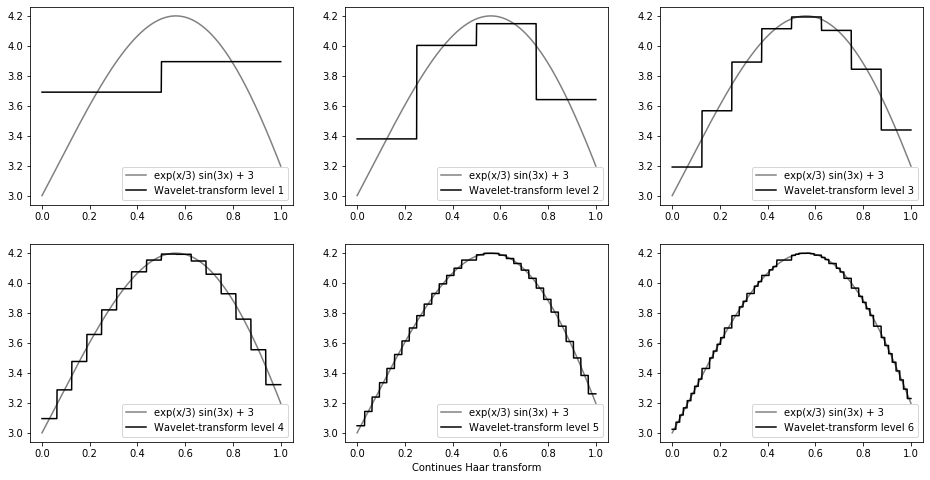

In [8]:
g = lambda x: np.exp(x / 3) * np.sin(3 * x) + 3
xs = np.linspace(1e-8, 1 - 1e-8, 1000)

decompose_by_levels(g, xs)

In [9]:
def decomposition(signal, wavelet='Haar'):
    wavelet = pywt.Wavelet(wavelet)
    signal_with_noise = signal + np.random.normal(0, 0.2, len(signal))

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 2, 1)
    plt.plot(signal, 'black', label='pure signal')
    plt.plot(signal_with_noise,'gray', label='noised signal', linewidth=0.5)
    plt.legend()

    coefs = pywt.wavedec(signal_with_noise, wavelet, level=8)
   
    plt.subplot(2, 2, 2)
    plt.plot(pywt.waverec(coefs, wavelet), 'black', label='Full recovery (8 levels)', linewidth=0.5)
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(pywt.waverec(coefs[:-2], wavelet), 'black', label='6 levels recovery', linewidth=0.5)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(pywt.waverec(coefs[:-5], wavelet), 'black', label='3 levels recovery', linewidth=0.5)
    plt.legend()
    
    plt.show()

## Также рассмотрим разложение Хаара 8 уровней с частичным восстановлением. Это может использоваться для того, чтобы сгладить данные, либо уменьшить их размерность

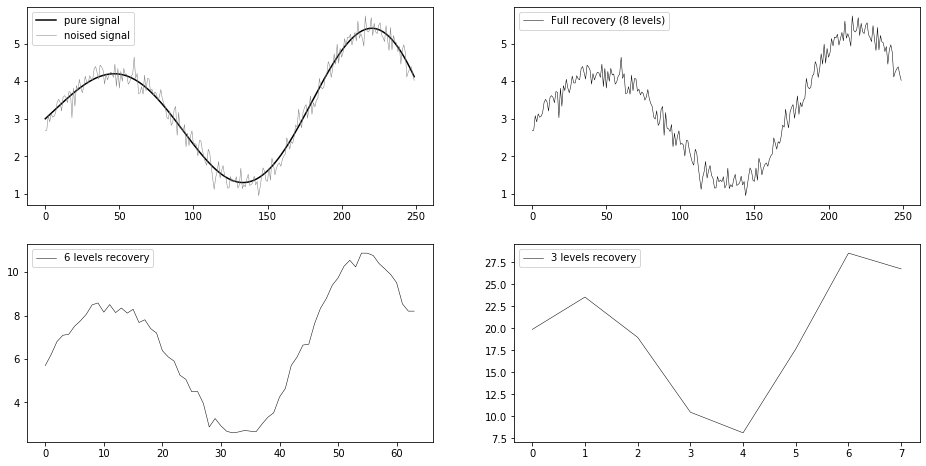

In [10]:
decomposition(g(np.linspace(0, 3, 250)))

In [11]:
def ShowSeries(series, wavelet='mexh'):
    test = sm.tsa.adfuller(series)
    
    plt.figure(figsize=(16, 3))
    plt.plot(series, 'Grey', linewidth=0.5)
    plt.xticks(())
    plt.yticks(())
    if test[0] > test[4]['5%']: 
        plt.title('Non-stationary series by Dickey-Fuller test')
    else:
        plt.title('Stationary series by Dickey-Fuller test')
        
    coef, freqs = pywt.cwt(series ,np.arange(1, 200), wavelet)
    plt.matshow(coef, cmap='Greys')
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])

## Стационарность - свойство процесса не менять свои характеристики со временем.

Временной ряд не является стационарным, если:
- растет мат. ожидание, т.е. существует тренд.
- дисперсия непостоянна.
- Данные, неравномерно распределены, т.е. есть непостоянство ковариаций.

Попробуем применить вейвлет преобразование и в этом направлении

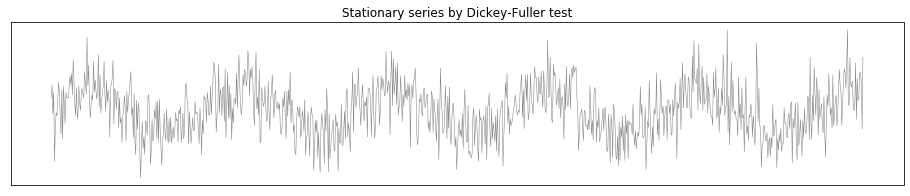

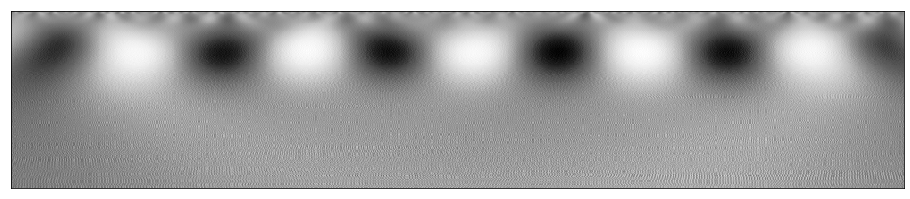

adf:  -3.481848853184378
p-value:  0.008465675598229853
Critical values:  {'1%': -3.4369860032923145, '5%': -2.8644697838498376, '10%': -2.5683299626694422}


In [12]:
noise = np.random.normal(0, 1, 1000)
x_range = np.arange(1000)

ShowSeries(np.sin(x_range / 30) + noise)

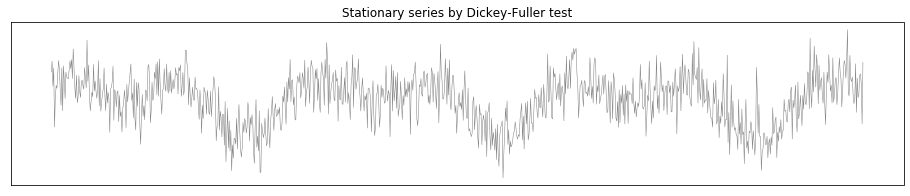

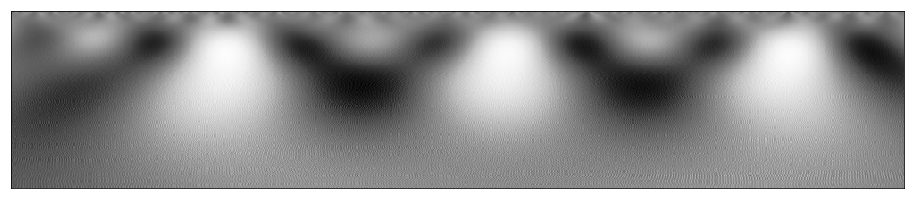

adf:  -2.903023162949968
p-value:  0.0449975725101061
Critical values:  {'1%': -3.4369860032923145, '5%': -2.8644697838498376, '10%': -2.5683299626694422}


In [13]:
ShowSeries(np.sin(x_range / 50) + np.sin(x_range / 25 - 5) + noise)

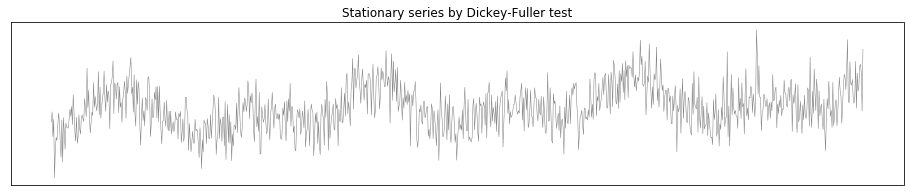

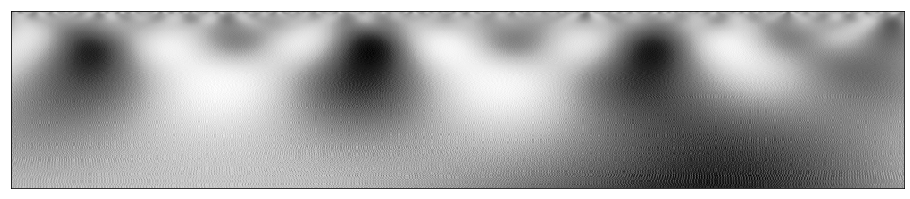

adf:  -3.276199205944301
p-value:  0.015976475379125093
Critical values:  {'1%': -3.4369860032923145, '5%': -2.8644697838498376, '10%': -2.5683299626694422}


In [14]:
ShowSeries(np.sin(x_range / 50) + np.sin(x_range / 25 - 2) + x_range / 500 + noise * 1.3)

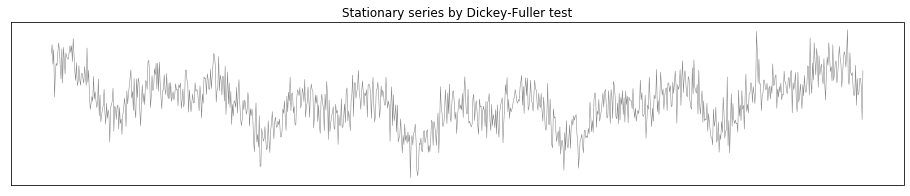

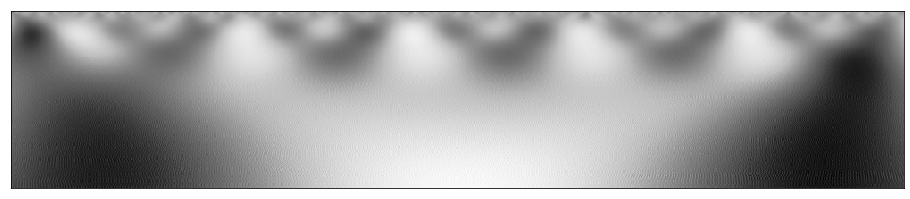

adf:  -3.185889894929999
p-value:  0.020816093463927047
Critical values:  {'1%': -3.4369658620871286, '5%': -2.8644609013346485, '10%': -2.56832523159495}


In [15]:
ShowSeries(np.sin(x_range / 30 + 2) + np.sin(x_range / 15) 
           + ((x_range - len(x_range) / 2) / 300)**2 + noise)

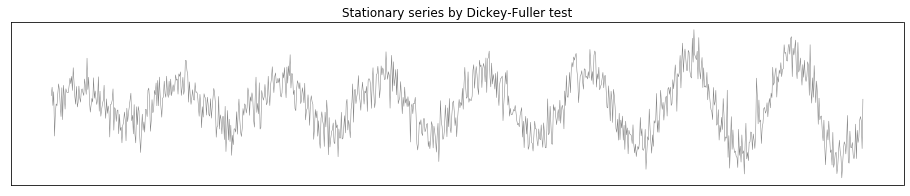

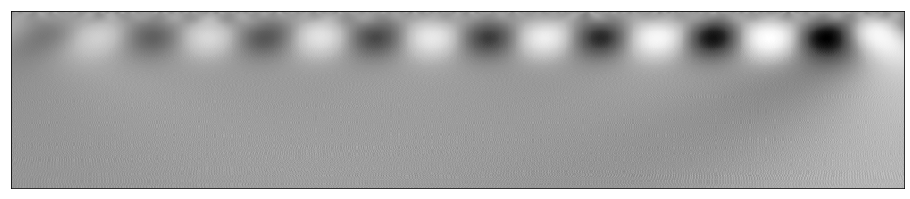

adf:  -5.770885118947002
p-value:  5.39587787602044e-07
Critical values:  {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}


In [16]:
ShowSeries((np.sin(x_range / 20)) * (x_range + len(x_range))**2 + noise * 1e6)

In [17]:
df = pd.read_csv('nss15.csv')

time = pd.to_datetime(df.treatmentDate, format='%m/%d/%Y')
timeseries = pd.Series(np.ones(len(time)), index=sorted(time), dtype=np.int64).resample('D').sum()

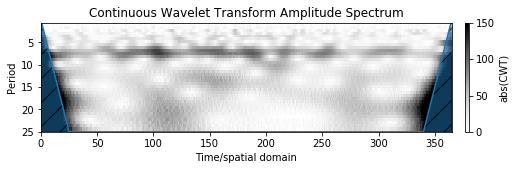

In [18]:
from scaleogram import cws

cws(timeseries, cmap='Greys', clim=[0, 150], figsize=(8, 2))
plt.show()

In [19]:
timeseries.index = pd.Series(timeseries.index).apply(lambda day: day.weekday())

In [20]:
dayweeks = ['понедельник', 'вторник', 'среду', 'четверг', 'пятницу', 'субботу', 'воскресенье']

for i in range(7):
    print('В {:12s} всего {} случаев, в среднем {:d}'
              .format(dayweeks[i], timeseries[i].sum(), int(timeseries[i].mean())))

В понедельник  всего 49868 случаев, в среднем 959
В вторник      всего 46629 случаев, в среднем 896
В среду        всего 46727 случаев, в среднем 898
В четверг      всего 46798 случаев, в среднем 882
В пятницу      всего 45269 случаев, в среднем 870
В субботу      всего 49408 случаев, в среднем 950
В воскресенье  всего 50140 случаев, в среднем 964


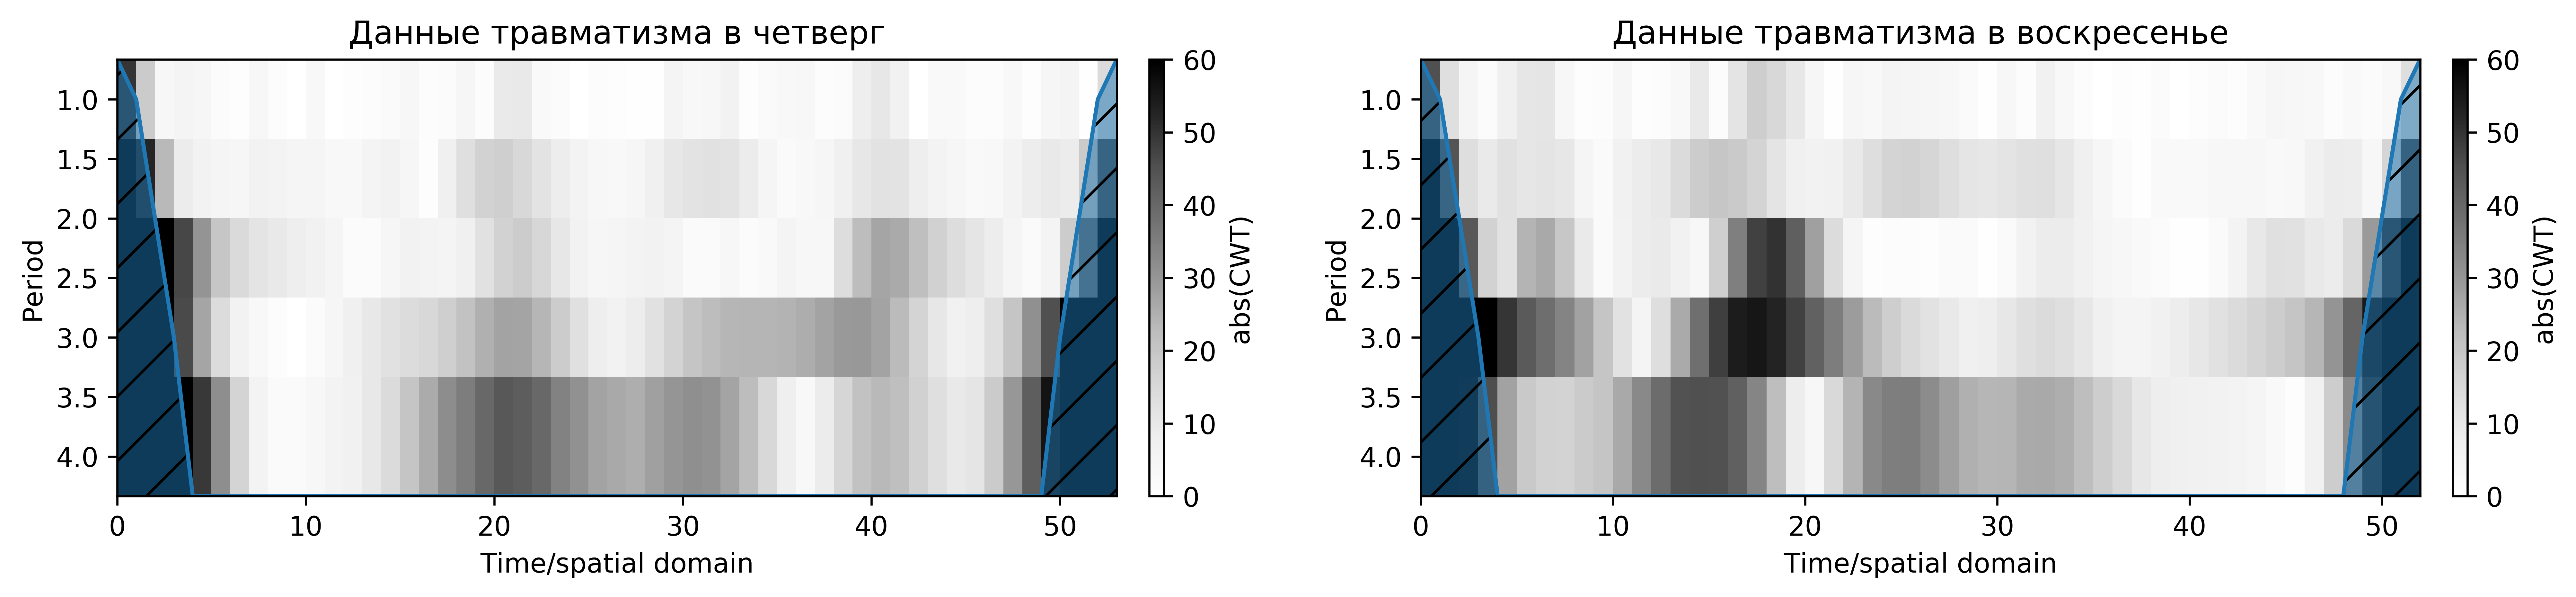

In [21]:
plt.figure(figsize=(16, 3), dpi=600)

ax = plt.subplot(1, 2, 1)
cws(timeseries[3], cmap='Greys', ax=ax, clim=[0, 60], title='Данные травматизма в %s' % dayweeks[3])

ax = plt.subplot(1, 2, 2)
cws(timeseries[6], cmap='Greys', ax=ax, clim=[0, 60], title='Данные травматизма в %s' % dayweeks[6])
plt.show()

Вейвлет преобразование позволяет сказать, когда именно были пики.

На скейлограмме темные области соответсвуют всплескам. По ним мы можем сказать, что большинство случаев травматизма в четверг приходится на середину года, а в субботу на апрель-май

Также можно увидеть, что внутри года закономерностей не наблюдается

# Спасибо за внимание!